# Analysis of live reported understanding ratings
from the Bach visualisation online study

Participants watched a relatively simple or complex visualisation of a concert performance of a Bach Fugue and reported changes in their level of understanding (?) from 1 (low) to 5 (high) while the music played. 

This notebook importes the changes in ratings in the edited response data file, interpolates for analysis, and reports the distributions of reported understanding over time for 4 conditions:

- simple1:  the simple visualisation ratings when seen first
- complex1: the complex visualisation ratings when send first
- simple2:  the simple visualisation ratings when seen second
- complex2: the complex visualisation ratings when send second


Simple:
https://youtu.be/00w8O77E1SA
Complex:
https://youtu.be/zdn9e9R4sAs

11:44 and 11:40

In [3]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d


#http://www.kennethmoreland.com/color-maps/
install.packages("heatmaply")
img(heatmaply::cool_warm(500), "Cool-warm, (Moreland 2009)")

In [4]:
A_df = pd.read_csv('./data_input/edited.csv')
print(len(A_df))

53


In [5]:
# Example of data format
A_df.loc[0,['complex1','simple1', 'complex2', 'simple2']]

complex1                                           NaN
simple1     13.87 5 M;37.19 3 M;85.49 4 M;668.32 3 51;
complex2                                           NaN
simple2                        215.18 4 M;653.02 3 51;
Name: 0, dtype: object

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
def button_parse(press_string):
    if(press_string != press_string):
        print(press_string)
        return         
    else:
        presses = press_string.split(';')
        Times = [0]
        Values = [0]
        Types = ['P']
        for p in presses:
            vals = p.split(' ')
            if len(vals) == 3:
                Times.append(float(vals[0]))
                Values.append(int(vals[1]))
                Types.append(vals[2])
        
        X = pd.DataFrame(columns = ['Time','Value','Type'])
        X['Time'] = Times
        X['Value'] = Values
        X['Type'] = Types
        return X
    
def make_step(press_string, sampletime):
    if(press_string != press_string):
        return ['no','buttons']        
    else:
        X = button_parse(press_string)
        f = interpolate.interp1d(X['Time'], X['Value'],kind='previous',fill_value="extrapolate") 
        return f(sampletime)   


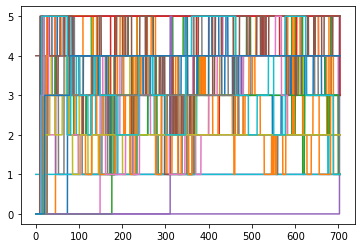

In [7]:
sampletime = np.arange(0.1,704, 0.1)
S = pd.DataFrame(index = sampletime)
for i in A_df.index:
    B = make_step(A_df.loc[i,'simple1'], sampletime)
    if len(B)>2:
        S[i] = B
        
S.plot(legend=False)
plt.show()

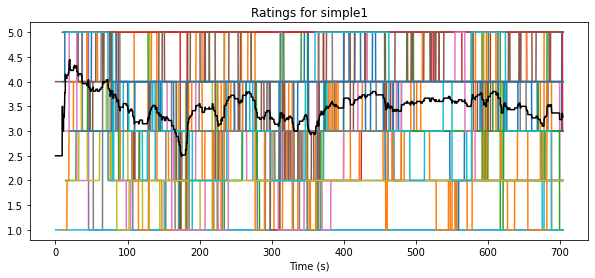

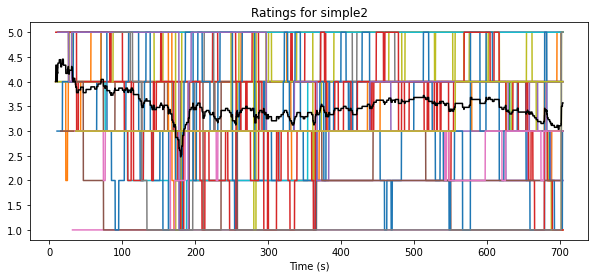

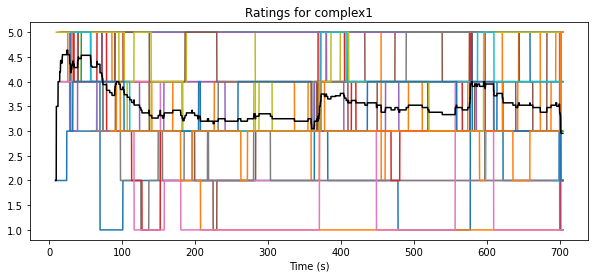

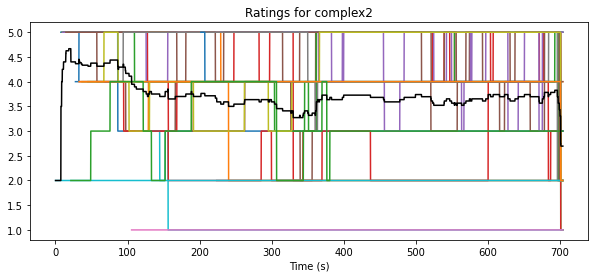

In [8]:
sampletime = np.arange(0.1,704, 0.1)
S_Means = pd.DataFrame(index = sampletime)
ContR = {}
for pres in ['simple1', 'simple2','complex1', 'complex2']:
    S = pd.DataFrame(index = sampletime)
    for i in A_df.index:
        B = make_step(A_df.loc[i,pres], sampletime)
        if len(B)>2:
            S[i] = B
    S=S.mask(S<1,np.nan)
    
    # save the results
    S_Means[pres] = S.mean(axis=1)
    S.mean(axis=1).to_csv('./data_output/' +pres + '_mean_10z.csv',index=True) # G.to_csv('./data_output/button_values_'+pres +'_10Hz.csv',index=True)
    S.to_csv('./data_output/' +pres + '_10z.csv',index=True) # G.to_csv('./data_output/button_values_'+pres +'_10Hz.csv',index=True)
    ContR[pres] = S
    
    # plot 
    S.plot(legend=False,figsize=[10,4])
    S.mean(axis=1).plot(color='k')
    plt.title('Ratings for ' + pres)
    plt.xlabel('Time (s)')
    plt.savefig('./plots/' + pres + '_step_and_mean_10z.png',dpi = 300)
    plt.show()


In [9]:
S.sum()

1     22473.0
2     23964.0
5     26263.0
7     31958.0
8     33460.0
9     27126.0
12    10110.0
13     9606.0
16    34470.0
17     6722.0
18    33767.0
19    16795.0
20    30139.0
23    17904.0
25    33296.0
27    33470.0
28     5984.0
30    29177.0
33    28897.0
35    14078.0
43    20111.0
45    26794.0
50    21311.0
dtype: float64

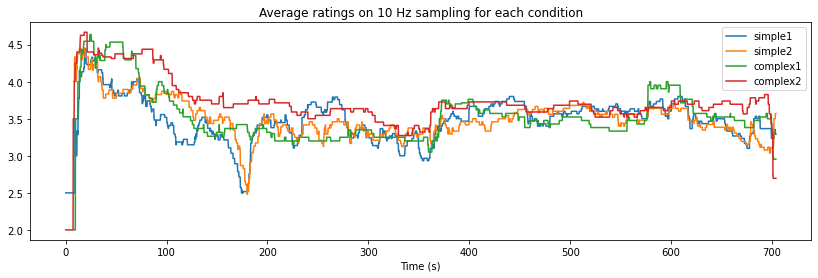

In [10]:
S_Means.plot(figsize=[14,4])
plt.title('Average ratings on 10 Hz sampling for each condition')
plt.xlabel('Time (s)')
plt.savefig('./plots/Means_10z.png',dpi = 300)
plt.show()

## Means of ratings depending on previous stimulus

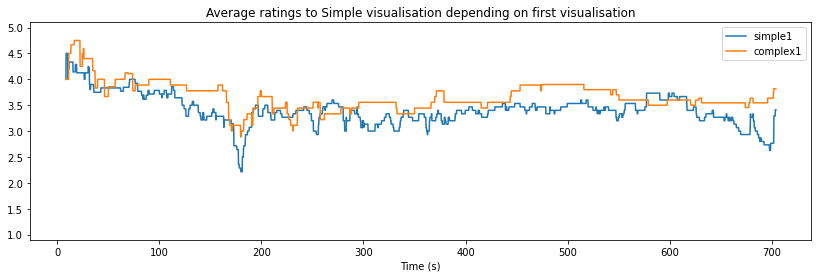

In [18]:
# conditions of prev
ContR['simple2'][list(set(ContR['simple1'].columns).intersection(set(ContR['simple2'].columns)))].mean(axis=1).plot(figsize=[14,4],label = 'simple1',legend=True)
ContR['simple2'][list(set(ContR['complex1'].columns).intersection(set(ContR['simple2'].columns)))].mean(axis=1).plot(label = 'complex1',legend=True)

plt.title('Average ratings to Simple visualisation depending on first visualisation')
plt.xlabel('Time (s)')
plt.ylim([0.9,5.1])
plt.savefig('./plots/Simple2_cond_Means_10z.png',dpi = 300)
plt.show()


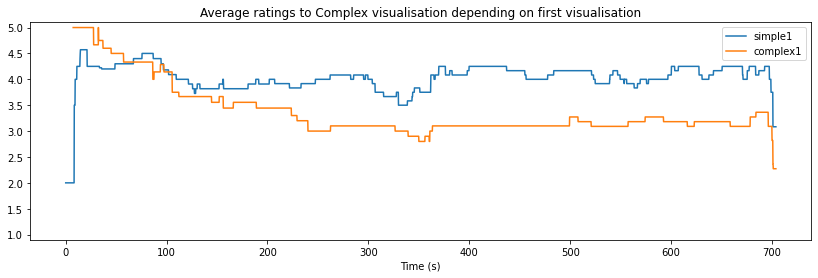

In [19]:
# conditions of prev
ContR['complex2'][list(set(ContR['simple1'].columns).intersection(set(ContR['complex2'].columns)))].mean(axis=1).plot(figsize=[14,4],label = 'simple1',legend=True)
ContR['complex2'][list(set(ContR['complex1'].columns).intersection(set(ContR['complex2'].columns)))].mean(axis=1).plot(label = 'complex1',legend=True)

plt.title('Average ratings to Complex visualisation depending on first visualisation')
plt.xlabel('Time (s)')
plt.ylim([0.9,5.1])
plt.savefig('./plots/Complex2_cond_Means_10z.png',dpi = 300)
plt.show()


# Distributions of ratings over time
Area plot that give distribution of reported values, showing when participants changed ratings

In [10]:
#plt.style.use('ggplot')
plt.style.use('default')
pal = ["#DDDDDD","#FFC300","#FF5733","#C70039","#900C3F","#581845"] # red
# CoolWarmFloat33.csv
# https://matplotlib.org/stable/gallery/color/colormap_reference.html

In [11]:
#col = sns.diverging_palette(220, 20, as_cmap=True)
col = sns.color_palette("bwr", as_cmap=True)
pct_max = 99 # for example, max percentile of color ramp
pct_min = 15 # for example, min percentile of color ramp
ramp = plt.cm.bwr # for example
# number of items in data source
n = 5

# list of values between 0.00 and 1.00; length equals length of data source
n_prop = list((100-i) / 100.0 for i in (np.arange(pct_min, pct_max, (pct_max-pct_min)/n)))
# create list of colors
clr_lst = [(0.6, 0.6, 0.6, 1.0)]
for i in n_prop:
    clr = ramp(i) 
    clr_lst.append(clr)

In [22]:
n_prop

[0.85, 0.682, 0.514, 0.3459999999999999, 0.17799999999999996]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


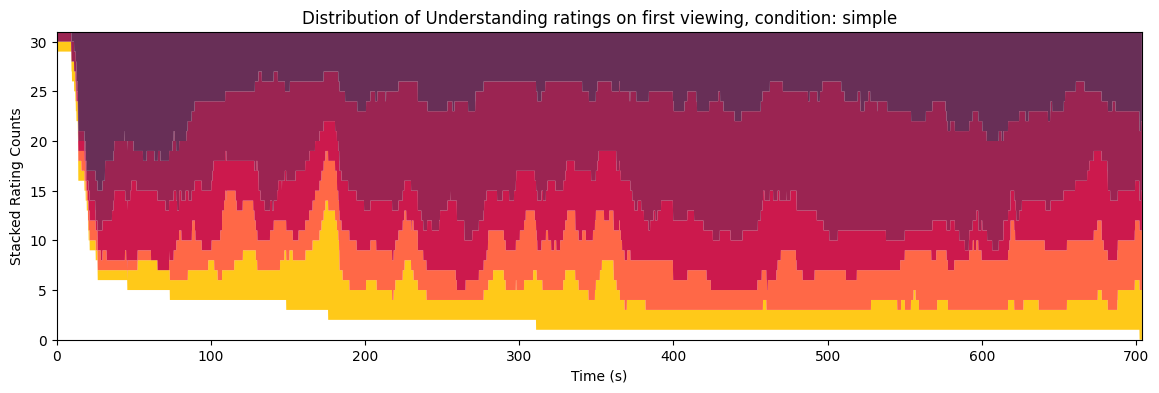

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


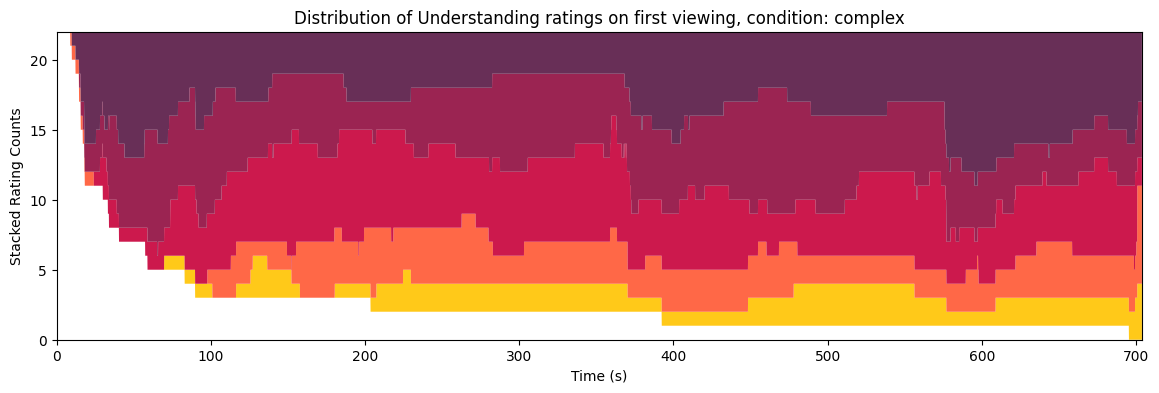

In [57]:
# count proportions of each value at each timestep 
# [NaN,1.0,2.0,3.0,4.0,5.0]
for pres in ['simple1','complex1']:
    B = ContR[pres]
    L = len(B.columns)
    G = pd.DataFrame(columns = [5.0,4.0,3.0,2.0,1.0],index = B.index)
    for i,row in B.iterrows(): # this is really slow. Maybe could be performed with mask instead 
        a = row.value_counts()
        G.loc[i,a.index] = a.values
    G['NaN']=len(B.columns)-G.sum(axis=1)
    G.fillna(0,inplace=True)
    G.to_csv('./data_output/button_values_'+pres +'_10Hz.csv',index=True)


    fig, ax = plt.subplots(figsize=[14,4])
    plt.stackplot(G.index,G[['NaN',1.0,2.0,3.0,4.0,5.0]].transpose().values, colors=pal, alpha=0.9) #labels=['NaN',1.0,2.0,3.0,4.0,5.0],

#     plt.legend()
    plt.title('Distribution of Understanding ratings on first viewing, condition: ' + pres[:-1])
    plt.xlabel('Time (s)')
    plt.ylabel('Stacked Rating Counts')
    plt.yticks(np.arange(0,L,5))
    plt.xlim([0,G.index[-1]])
    plt.ylim([0,L])
    plt.savefig('./plots/' + pres + '_Area_dist_10z.eps',format = 'eps')
#     plt.savefig('./plots/' + pres + '_Area_dist_10z.png',dpi = 300)
    plt.show()

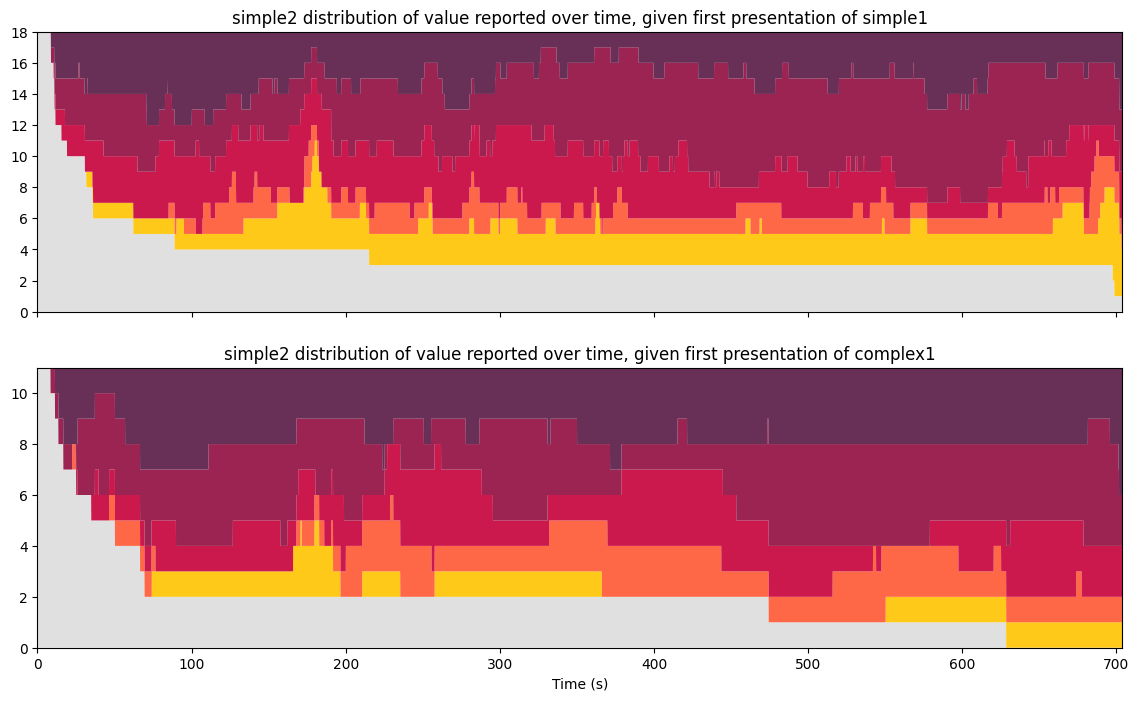

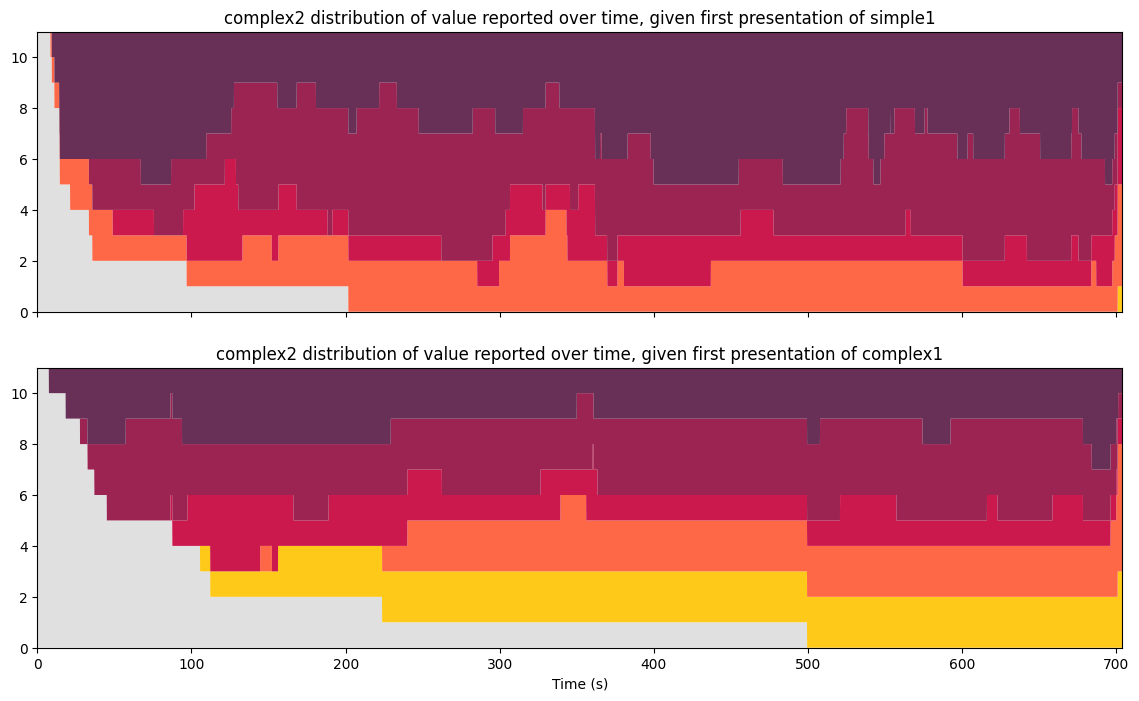

In [61]:
# count proportions of each value at each timestep 
# [NaN,1.0,2.0,3.0,4.0,5.0]
for pres in ['simple2','complex2']:
    fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True,figsize=[14,8])
    
    B = ContR[pres][list(set(ContR['simple1'].columns).intersection(set(ContR[pres].columns)))]
    G = pd.DataFrame(columns = [5.0,4.0,3.0,2.0,1.0],index = B.index)
    for i,row in B.iterrows(): # this is really slow. Maybe could be performed with mask instead 
        a = row.value_counts()
        G.loc[i,a.index] = a.values
    G['NaN']=len(B.columns)-G.sum(axis=1)
    G.fillna(0,inplace=True)
    G.to_csv('./data_output/button_values_'+pres +'_simple1_10Hz.csv',index=True)
    
    ax1.set_title(pres + ' distribution of value reported over time, given first presentation of simple1')
    ax1.stackplot(G.index,G[['NaN',1.0,2.0,3.0,4.0,5.0]].transpose().values,labels=['NaN',1.0,2.0,3.0,4.0,5.0], colors=pal, alpha=0.9)
    ax1.set_ylim([0,G.max().max()])
    
    B = ContR[pres][list(set(ContR['complex1'].columns).intersection(set(ContR[pres].columns)))]
    G = pd.DataFrame(columns = [5.0,4.0,3.0,2.0,1.0],index = B.index)
    for i,row in B.iterrows(): # this is really slow. Maybe could be performed with mask instead 
        a = row.value_counts()
        G.loc[i,a.index] = a.values
    G['NaN']=len(B.columns)-G.sum(axis=1)
    G.fillna(0,inplace=True)
    G.to_csv('./data_output/button_values_'+pres +'_complex1_10Hz.csv',index=True)
    ax2.set_title(pres + ' distribution of value reported over time, given first presentation of complex1')
    ax2.stackplot(G.index,G[['NaN',1.0,2.0,3.0,4.0,5.0]].transpose().values,labels=['NaN',1.0,2.0,3.0,4.0,5.0], colors=pal, alpha=0.9)
    ax2.set_title(pres + ' distribution of value reported over time, given first presentation of complex1')
    ax2.set_xlabel('Time (s)')
    ax2.set_xlim([0,G.index[-1]])
    ax2.set_ylim([0,G.max().max()])
    
    plt.savefig('./plots/' + pres + '_split_Area_dist_10z.png',dpi = 300)
    plt.show()

# ordered learning plots, first second viewings.

per pair of stimulus conditions, plot participant-wise understanding plots, ordered by total understanding on first viewing

https://matplotlib.org/stable/tutorials/colors/colormaps.html

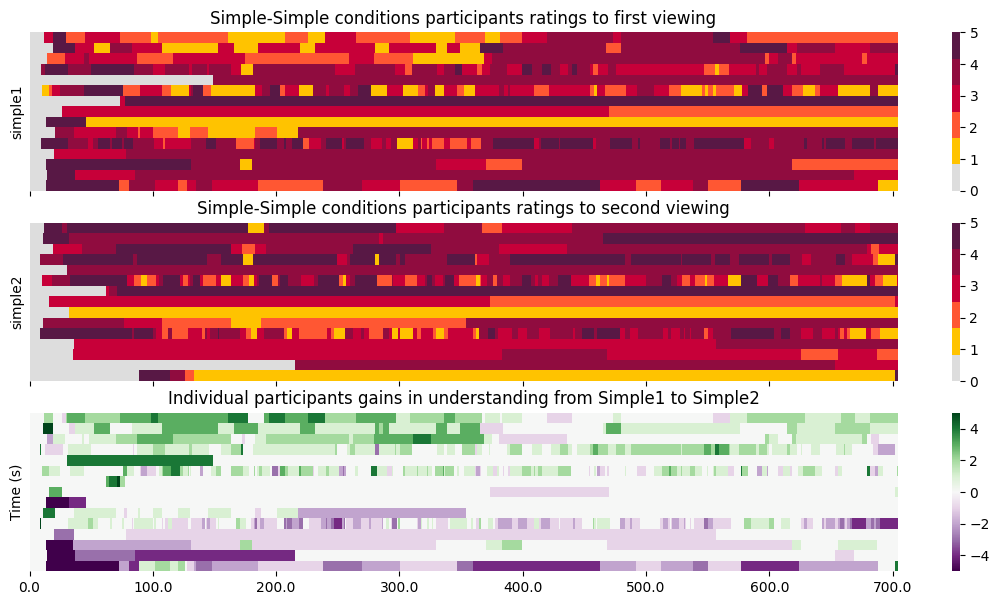

In [74]:
v1 = 'simple1'
v2 = 'simple2'
#ss_list = list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))
ss_list = [0, 32, 34, 39, 41, 14, 46, 47, 48, 51, 52, 21, 22, 24, 26] # exclude 44, 42, 29 for insufficient participation across both viewings
A = ContR[v1][ss_list]
A.fillna(0,inplace=True)
B = ContR[v2][ss_list]
B.fillna(0,inplace=True)
df_A = B.copy() - A.copy()
Und_Ord = df_A.sum().sort_values(ascending=False).index

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,sharex=True,figsize=[14,7])
df_A = A[Und_Ord].copy()
chart = sns.heatmap(data=df_A.transpose(), ax=ax1,vmin=0, vmax=5,cmap=pal)
ax1.set_yticks([])
ax1.set_ylabel(v1)
ax1.set_title('Simple-Simple conditions participants ratings to first viewing')

df_A = B[Und_Ord].copy()
chart = sns.heatmap(data=df_A.transpose(), ax=ax2,vmin=0, vmax=5,cmap=pal)
ax2.set_yticks([])
ax2.set_ylabel(v2)
ax2.set_title('Simple-Simple conditions participants ratings to second viewing')

df_A = B[Und_Ord].copy() - A[Und_Ord].copy()
chart = sns.heatmap(data=df_A.transpose(), ax=ax3,vmin=-5, vmax=5,cmap='PRGn')
ax3.set_xticks(np.arange(0,df_A.index[-1]*10,1000))
ax3.set_xticklabels(np.arange(0,df_A.index[-1],100),rotation = 'horizontal' )
ax3.set_yticks([])
ax3.set_ylabel('Gains')
ax3.set_ylabel('Time (s)')
ax3.set_title('Individual participants gains in understanding from Simple1 to Simple2')

# plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.png',dpi = 300)
plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.eps',format = 'eps')
plt.show()

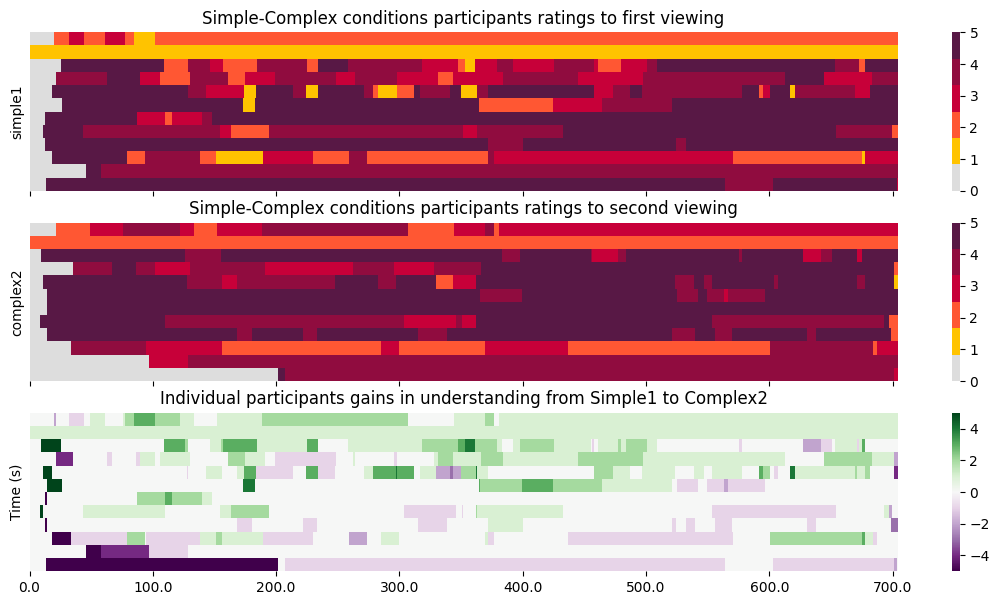

In [80]:
v1 = 'simple1'
v2 = 'complex2'
ss_list = list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))
A = ContR[v1][ss_list]
A.fillna(0,inplace=True)
B = ContR[v2][ss_list]
B.fillna(0,inplace=True)
df_A = B.copy() - A.copy()
Und_Ord = df_A.sum().sort_values(ascending=False).index

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,sharex=True,figsize=[14,7])
df_A = A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax1,vmin=0, vmax=5,cmap=pal)
ax1.set_yticks([])
ax1.set_ylabel(v1)
ax1.set_title('Simple-Complex conditions participants ratings to first viewing')

df_A = B[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax2,vmin=0, vmax=5,cmap=pal)
ax2.set_yticks([])
ax2.set_ylabel(v2)
ax2.set_title('Simple-Complex conditions participants ratings to second viewing')

df_A = B[Und_Ord].copy() - A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax3,vmin=-5, vmax=5,cmap='PRGn')
ax3.set_xticks(np.arange(0,df_A.index[-1]*10,1000))
ax3.set_xticklabels(np.arange(0,df_A.index[-1],100),rotation = 'horizontal' )
ax3.set_yticks([])
ax3.set_ylabel('Gains')
ax3.set_ylabel('Time (s)')
ax3.set_title('Individual participants gains in understanding from Simple1 to Complex2')
# print([df_A.mean().median(),df_A.mean().std()])
# print([df_A.sum().median(),df_A.sum().std()])

# plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.png',dpi = 300)
plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.eps',format = 'eps')
plt.show()

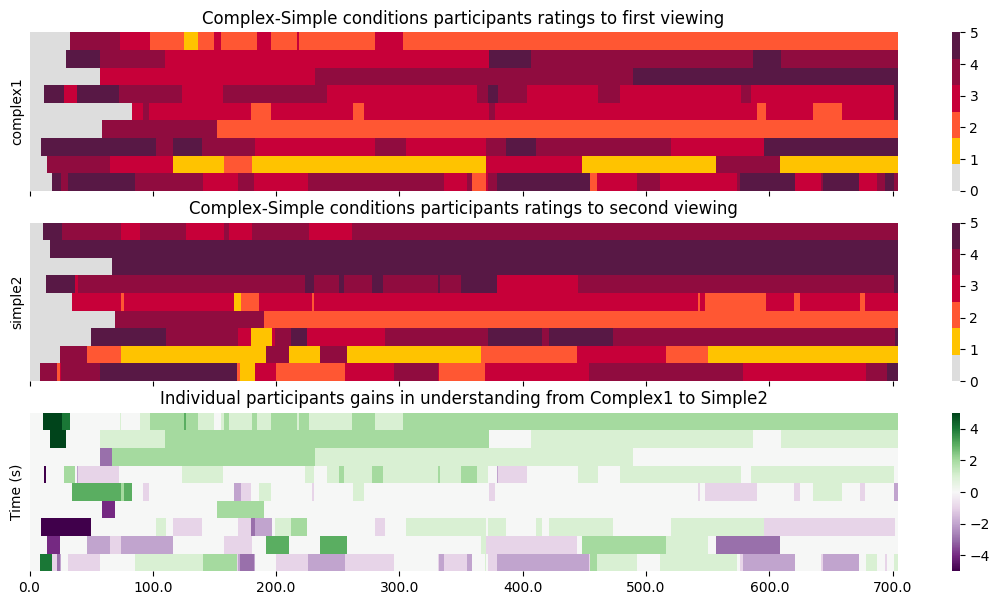

In [88]:
v1 = 'complex1'
v2 = 'simple2'
#ss_list = list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))
ss_list = [11, 40, 37, 6, 49, 10, 38, 36, 3] # excluding 4, 15 for incomplete participation
A = ContR[v1][ss_list]
A.fillna(0,inplace=True)
B = ContR[v2][ss_list]
B.fillna(0,inplace=True)
df_A = B.copy() - A.copy()
Und_Ord = df_A.sum().sort_values(ascending=False).index

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,sharex=True,figsize=[14,7])
df_A = A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax1,vmin=0, vmax=5,cmap=pal)
ax1.set_yticks([])
ax1.set_ylabel(v1)
ax1.set_title('Complex-Simple conditions participants ratings to first viewing')

df_A = B[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax2,vmin=0, vmax=5,cmap=pal)
ax2.set_yticks([])
ax2.set_ylabel(v2)
ax2.set_title('Complex-Simple conditions participants ratings to second viewing')

df_A = B[Und_Ord].copy() - A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax3,vmin=-5, vmax=5,cmap='PRGn')
ax3.set_xticks(np.arange(0,df_A.index[-1]*10,1000))
ax3.set_xticklabels(np.arange(0,df_A.index[-1],100),rotation = 'horizontal' )
ax3.set_yticks([])
ax3.set_ylabel('Gains')
ax3.set_ylabel('Time (s)')

ax3.set_title('Individual participants gains in understanding from Complex1 to Simple2')
# print([df_A.mean().median(),df_A.mean().std()])
# print([df_A.sum().median(),df_A.sum().std()])

# plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.png',dpi = 300)
plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.eps',format = 'eps')
plt.show()

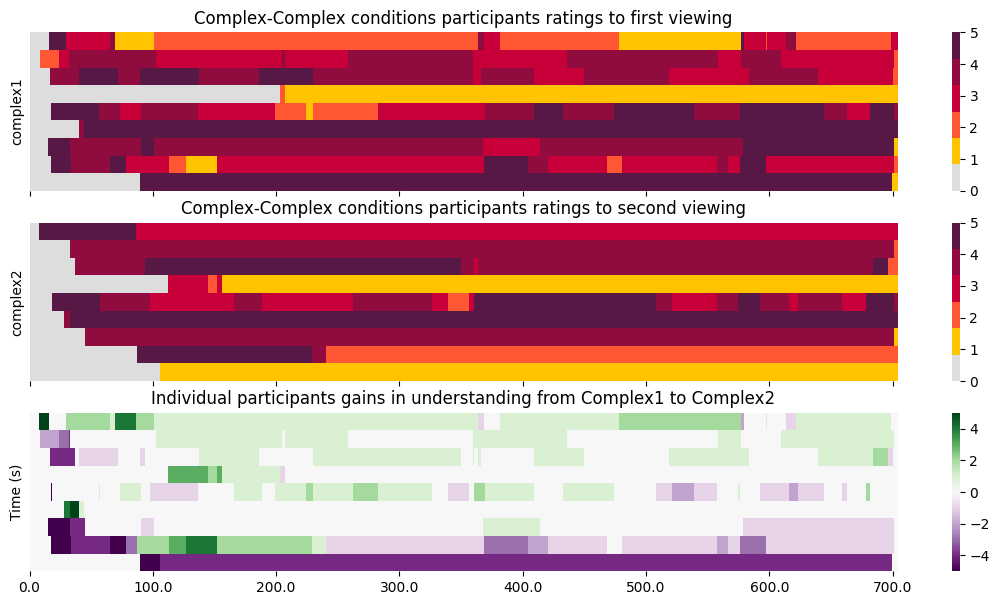

In [99]:
v1 = 'complex1'
v2 = 'complex2'
# ss_list = list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))
ss_list = [1, 45, 30, 17, 9, 18, 5, 19, 28] # excluding 13, 12 for incomplete participation
A = ContR[v1][ss_list]
A.fillna(0,inplace=True)
B = ContR[v2][ss_list]
B.fillna(0,inplace=True)
df_A = B.copy() - A.copy()
Und_Ord = df_A.sum().sort_values(ascending=False).index

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,sharex=True,figsize=[14,7])
df_A = A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax1,vmin=0, vmax=5,cmap=pal)
ax1.set_yticks([])
ax1.set_ylabel(v1)
ax1.set_title('Complex-Complex conditions participants ratings to first viewing')

df_A = B[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax2,vmin=0, vmax=5,cmap=pal)
ax2.set_yticks([])
ax2.set_ylabel(v2)
ax2.set_title('Complex-Complex conditions participants ratings to second viewing')

df_A = B[Und_Ord].copy() - A[Und_Ord].copy()
df_A.fillna(0,inplace=True)
chart = sns.heatmap(data=df_A.transpose(), ax=ax3,vmin=-5, vmax=5,cmap='PRGn')
ax3.set_xticks(np.arange(0,df_A.index[-1]*10,1000))
ax3.set_xticklabels(np.arange(0,df_A.index[-1],100),rotation = 'horizontal' )
ax3.set_yticks([])
ax3.set_ylabel('Gains')
ax3.set_ylabel('Time (s)')

ax3.set_title('Individual participants gains in understanding from Complex1 to Complex2')
# print([df_A.mean().median(),df_A.mean().std()])
# print([df_A.sum().median(),df_A.sum().std()])

# plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.png',dpi = 300)
plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains.eps',format = 'eps')
plt.show()

In [95]:
list(set(ContR[v1].columns).intersection(set(ContR[v2].columns))) # 13, 12
Und_Ord

Int64Index([13, 1, 45, 30, 17, 9, 18, 5, 19, 12, 28], dtype='int64')

In [96]:
df_A = B.copy() - A.copy()
df_A.sum().sort_values(ascending=False)


13     9436.0
1      8280.0
45     2836.0
30     2252.0
17     1679.0
9      1117.0
18      618.0
5     -2235.0
19    -5286.0
12   -21808.0
28   -24551.0
dtype: float64

In [97]:
A.sum()

1     14193.0
5     28498.0
9     26009.0
12    31918.0
13      170.0
45    23958.0
17     5043.0
18    33149.0
19    22081.0
28    30535.0
30    26925.0
dtype: float64

In [98]:
B.sum() # exclude 44, 42, 29

1     22473.0
5     26263.0
9     27126.0
12    10110.0
13     9606.0
45    26794.0
17     6722.0
18    33767.0
19    16795.0
28     5984.0
30    29177.0
dtype: float64

# Figures demandés

Premiere figure, avec superposition de:
simple1_Area_dist
simple1_simple2_indiv_gains
simple1_complex2_indiv_gains

Deuxième figure, avec superposition de:
complex1_Area_dist
complex1_simple2_indiv_gains
complex1_complex2_indiv_gains

Qu’en penses-tu ?
Je peux aussi ajouter dans chaque figure une ligne d’analyse de la structure de la pièce en grandes parties.

Peux-tu par hasard créer toutes les figures en format vectoriel (EPS, PDF, …) ?

Pourrais-tu enlever les légendes de couleurs ? En particulier dans les figures Area_dist ?

En une gradation de 5 en 5 sur l’axe Y de complex1_Area_dist ?

Comme je couperai les images, je pourrai enlever moi-même les gradations X et Y et les titres dans indiv_gains, etc.
Merci de corriger le code couleur de simple1_complex2_indiv_gains qui est bizarre


In [157]:
#col = sns.diverging_palette(220, 20, as_cmap=True)
#https://matplotlib.org/stable/gallery/color/colormap_reference.html
    
col = sns.color_palette("RdBu", as_cmap=True) # bwr "seismic"
pct_max = 99 # for example, max percentile of color ramp
pct_min = 15 # for example, min percentile of color ramp
ramp = plt.cm.inferno# for example
# number of items in data source
n = 5

# list of values between 0.00 and 1.00; length equals length of data source
n_prop = list((100-i) / 100.0 for i in (np.arange(pct_min, pct_max, (pct_max-pct_min)/n)))
#n_prop = list(i / 100.0 for i in (np.arange(pct_min, pct_max, (pct_max-pct_min)/n)))

# create list of colors
clr_lst = [(0.6, 0.6, 0.6, 1.0)]
for i in n_prop:
    clr = ramp(i) 
    clr_lst.append(clr)

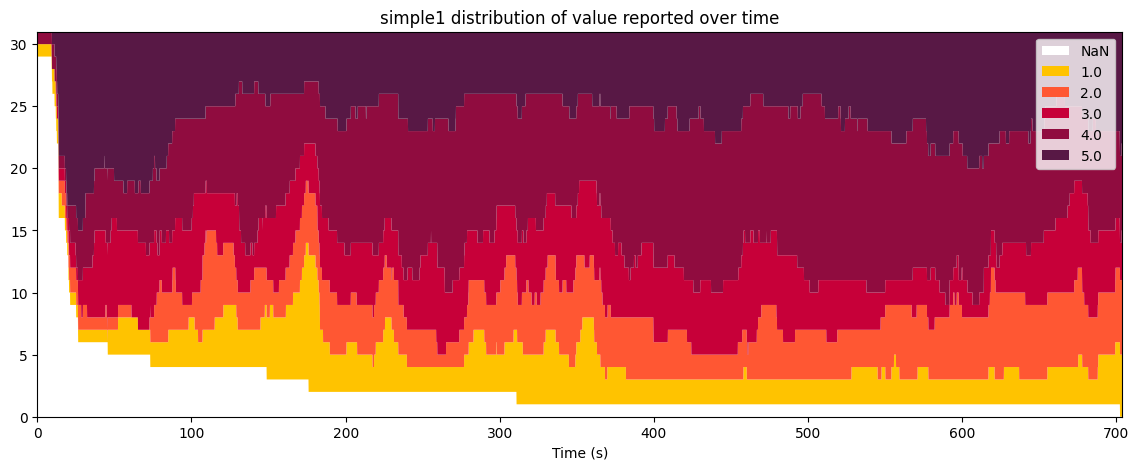

In [56]:
# test colours

pres = 'simple1'
B = ContR[pres]
G = pd.DataFrame(columns = [5.0,4.0,3.0,2.0,1.0],index = B.index)
for i,row in B.iterrows(): # this is really slow. Maybe could be performed with mask instead 
    a = row.value_counts()
    G.loc[i,a.index] = a.values
G['NaN']=len(B.columns)-G.sum(axis=1)
G.fillna(0,inplace=True)

fig, ax = plt.subplots(figsize=[14,5])
#    plt.stackplot(G.index,G[['NaN',1.0,2.0,3.0,4.0,5.0]].transpose().values,labels=['NaN',1.0,2.0,3.0,4.0,5.0], colors=clr_lst, alpha=0.9)
plt.stackplot(G.index,G[['NaN',1.0,2.0,3.0,4.0,5.0]].transpose().values,labels=['NaN',1.0,2.0,3.0,4.0,5.0], colors=pal, alpha=1)

plt.legend()
plt.title(pres + ' distribution of value reported over time')
plt.xlabel('Time (s)')
plt.xlim([0,max(G.index)])
plt.ylim([0,len(B.columns)])
# plt.xlim([0,700])
# plt.ylim([0,G.max().max()])
#   plt.savefig('./plots/' + pres + '_Area_dist_10z.png',dpi = 300)
plt.show()

[-0.0024151157834919734, 0.7937759647705503]
[-17.0, 5587.3890160199035]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[1847.5, 3600.211315346853]


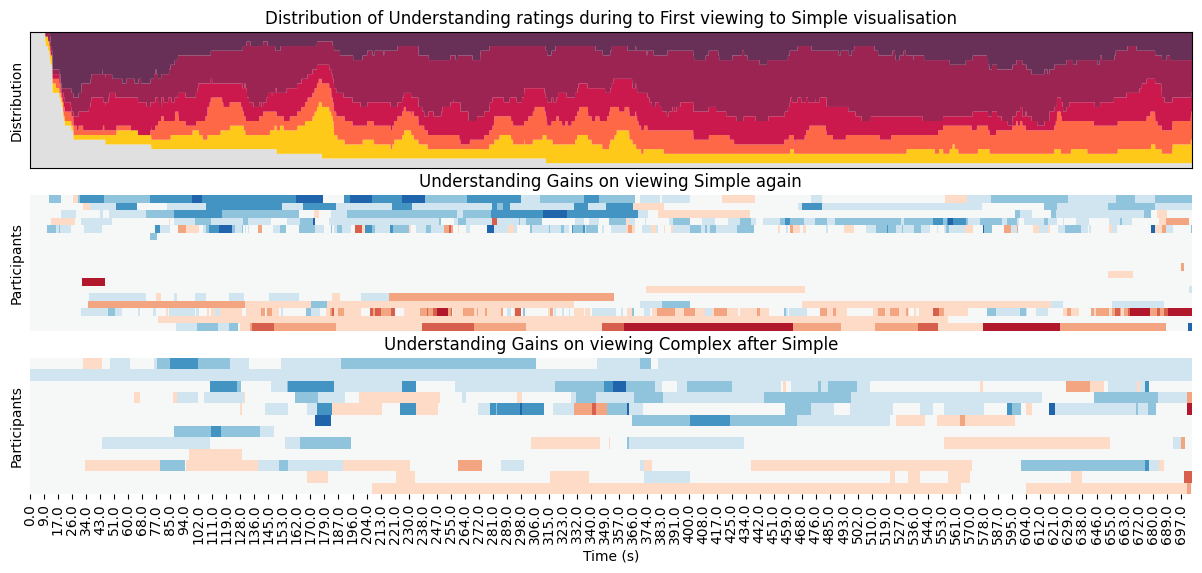

In [166]:
# simple1_Area_dist 
# simple1_simple2_indiv_gains 
# simple1_complex2_indiv_gains
fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=[15,6])

# count proportions of each value at each timestep 
# [NaN,1.0,2.0,3.0,4.0,5.0]
v1 = 'simple1' #'complex1'
B = ContR[v1]
G = pd.DataFrame(columns = [5.0,4.0,3.0,2.0,1.0],index = B.index)
for i,row in B.iterrows(): # this is really slow. Maybe could be performed with mask instead 
    a = row.value_counts()
    G.loc[i,a.index] = a.values
G['NaN']=len(B.columns)-G.sum(axis=1)
G.fillna(0,inplace=True)

ax1.stackplot(G.index,G[['NaN',1.0,2.0,3.0,4.0,5.0]].transpose().values,
              labels=['NaN',1.0,2.0,3.0,4.0,5.0], colors=pal, alpha=0.9) # pal
ax1.set_title('Distribution of Understanding ratings during to First viewing to Simple visualisation')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('Distribution')
ax1.set_xlim([0,700])
ax1.set_ylim([0,G.max().max()])

v2 = 'simple2'
A = ContR[v1][list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))]
B = ContR[v2][list(set(ContR[v2].columns).intersection(set(ContR[v1].columns)))]
df_A = B.copy() - A.copy()
Und_Ord = df_A.sum().sort_values(ascending=False).index
df_A.fillna(0,inplace=True)

chart = sns.heatmap(data=df_A[Und_Ord].transpose(), ax=ax2,vmin=-5, vmax=5,cmap=col,cbar=False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel('Participants')
ax2.set_title('Understanding Gains on viewing Simple again')
print([df_A.mean().median(),df_A.mean().std()])
print([df_A.sum().median(),df_A.sum().std()])

v2 = 'complex2'
A = ContR[v1][list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))]
B = ContR[v2][list(set(ContR[v2].columns).intersection(set(ContR[v1].columns)))]
df_A = B.copy() - A.copy()
Und_Ord = df_A.sum().sort_values(ascending=False).index
df_A.fillna(0,inplace=True)

chart = sns.heatmap(data=df_A[Und_Ord].transpose(), ax=ax3,vmin=-5, vmax=5,cmap=col,cbar=False)
ax3.set_xticklabels(np.round(df_A.iloc[ax3.get_xticks()].index))
ax3.set_xlabel('Time (s)')
ax3.set_yticks([])
ax3.set_ylabel('Participants')
ax3.set_title('Understanding Gains on viewing Complex after Simple')
print([df_A.sum().median(),df_A.sum().std()])

plt.savefig('./plots/' + v1 + '_compound_gains.eps', format='eps')
plt.show()

In [163]:
df_A[Und_Ord].sum()

50    7545.0
35    7039.0
25    5656.0
33    4804.0
7     3378.0
8     2508.0
16    1187.0
20     659.0
2     -320.0
23    -333.0
27    -647.0
43   -4592.0
dtype: float64

In [150]:
df_A.sum().sort_values(ascending=False)

50    7545.0
35    7039.0
25    5656.0
33    4804.0
7     3378.0
8     2508.0
16    1187.0
20     659.0
2     -320.0
23    -333.0
27    -647.0
43   -4592.0
dtype: float64

NameError: name 'col' is not defined

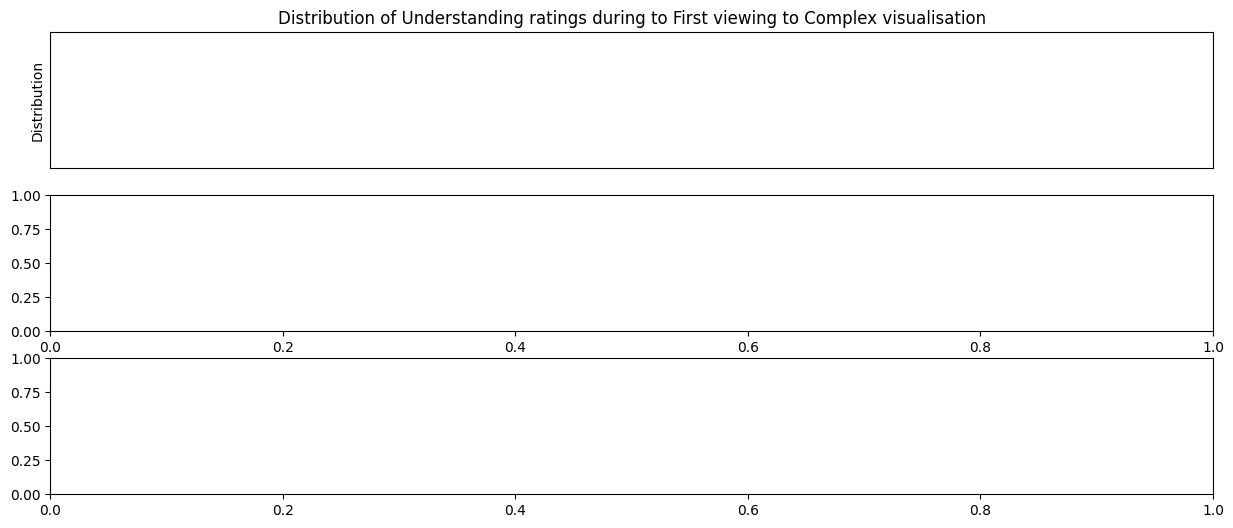

In [55]:
# simple1_Area_dist 
# simple1_simple2_indiv_gains 
# simple1_complex2_indiv_gains
fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=[15,6])

# count proportions of each value at each timestep 
# [NaN,1.0,2.0,3.0,4.0,5.0]
v1 = 'complex1' #'complex1'
B = ContR[v1]
G = pd.DataFrame(columns = [5.0,4.0,3.0,2.0,1.0],index = B.index)
for i,row in B.iterrows(): # this is really slow. Maybe could be performed with mask instead 
    a = row.value_counts()
    G.loc[i,a.index] = a.values
G['NaN']=len(B.columns)-G.sum(axis=1)
G.fillna(0,inplace=True)

ax1.stackplot(G.index,G[['NaN',1.0,2.0,3.0,4.0,5.0]].transpose().values,
              labels=['NaN',1.0,2.0,3.0,4.0,5.0], colors=pal, alpha=0.9) # pal
ax1.set_title('Distribution of Understanding ratings during to First viewing to Complex visualisation')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('Distribution')
ax1.set_xlim([0,len(B.columns)])
ax1.set_ylim([0,len(ss_list)])

v2 = 'simple2'
A = ContR[v1][list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))]
B = ContR[v2][list(set(ContR[v2].columns).intersection(set(ContR[v1].columns)))]
df_A = B.copy() - A.copy()
Und_Ord = df_A.sum().sort_values(ascending=False).index
df_A.fillna(0,inplace=True)

chart = sns.heatmap(data=df_A[Und_Ord].transpose(), ax=ax2,vmin=-5, vmax=5,cmap=col,cbar=False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel('Participants')
ax2.set_title('Understanding Gains on viewing Simple after Complex')
print([df_A.mean().median(),df_A.mean().std()])
print([df_A.sum().median(),df_A.sum().std()])

v2 = 'complex2'
A = ContR[v1][list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))]
B = ContR[v2][list(set(ContR[v2].columns).intersection(set(ContR[v1].columns)))]
df_A = B.copy() - A.copy()
Und_Ord = df_A.sum().sort_values(ascending=False).index
df_A.fillna(0,inplace=True)

chart = sns.heatmap(data=df_A[Und_Ord].transpose(), ax=ax3,vmin=-5, vmax=5,cmap=col,cbar=False)
ax3.set_xticklabels(np.round(df_A.iloc[ax3.get_xticks()].index,0))
ax3.set_xlabel('Time (s)')
ax3.set_yticks([])
ax3.set_ylabel('Participants')
ax3.set_title('Understanding Gains on viewing Complex again')
print([df_A.sum().median(),df_A.sum().std()])

plt.savefig('./plots/' + v1 + '_compound_gains.eps', format='eps')
plt.show()

# Paper figures, four part

In [11]:
from matplotlib import gridspec

In [12]:
#plt.style.use('ggplot')
plt.style.use('default')
pal = ["#FFFFFF","#FFC300","#FF5733","#C70039","#900C3F","#581845"] # red

# pal = ["#DDDDDD","#FFC300","#FF5733","#C70039","#900C3F","#581845"] # red
# CoolWarmFloat33.csv
# https://matplotlib.org/stable/gallery/color/colormap_reference.html

In [45]:
v1 = 'simple1'
v2 = 'simple2'
cond_tag = 'Simple-Simple condition'
ss_list = [0, 32, 34, 39, 41, 14, 46, 47, 48, 51, 52, 21, 22, 24, 26] # exclude 44, 42, 29 for insufficient participation across both viewings


In [49]:
v1 = 'simple1'
v2 = 'complex2'
cond_tag = 'Simple-Complex condition'

ss_list = list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))


In [51]:
v1 = 'complex1'
v2 = 'simple2'
cond_tag = 'Complex-Simple condition'

#ss_list = list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))
ss_list = [11, 40, 37, 6, 49, 10, 38, 36, 3] # excluding 4, 15 for incomplete participation


In [53]:
v1 = 'complex1'
v2 = 'complex2'
cond_tag = 'Complex-Complex condition'

# ss_list = list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))
ss_list = [1, 45, 30, 17, 9, 18, 5, 19, 28] # excluding 13, 12 for incomplete participation


In [37]:
len(ss_list)

12

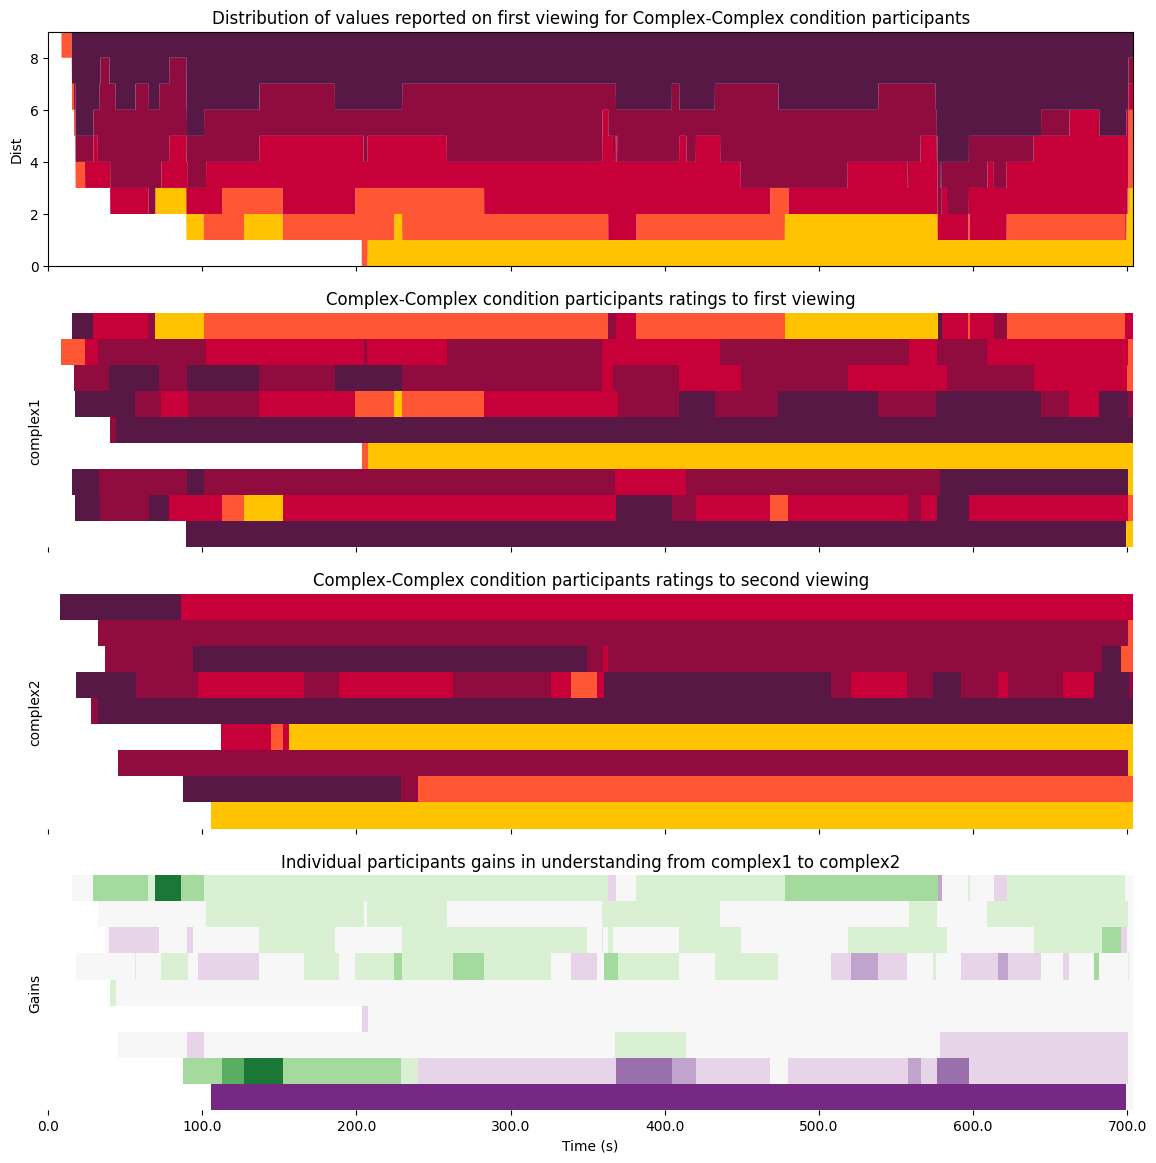

In [54]:
#ss_list = list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))
A = ContR[v1][ss_list]
#A.fillna(0,inplace=True)
B = ContR[v2][ss_list]
#B.fillna(0,inplace=True)
df_A = B.copy() - A.copy()
df_A.fillna(0,inplace=True)
Und_Ord = df_A.sum().sort_values(ascending=False).index

#fig, (ax0,ax1,ax2,ax3) = plt.subplots(4, 1,figsize=[12,12])
fig = plt.figure(figsize=[14,14])
spec = gridspec.GridSpec(ncols=1, nrows=4,)

G = pd.DataFrame(columns = [5.0,4.0,3.0,2.0,1.0],index = A.index)
for i,row in A.iterrows(): # this is really slow. Maybe could be performed with mask instead 
    a = row.value_counts()
    G.loc[i,a.index] = a.values
G['NaN']=len(A.columns)-G.sum(axis=1)
G.fillna(0,inplace=True)

ax0 = fig.add_subplot(spec[0])
ax0.stackplot(G.index,G[['NaN',1.0,2.0,3.0,4.0,5.0]].transpose().values,labels=['NaN',1.0,2.0,3.0,4.0,5.0], colors=pal, alpha=1)
#ax0.legend()
ax0.set_title('Distribution of values reported on first viewing for '+ cond_tag +' participants')
ax0.set_xlabel('')
ax0.set_ylabel('Dist')
ax0.set_xlim([0,max(G.index)])
ax0.set_ylim([0,len(ss_list)])
ax0.set_xticklabels([])

ax1 = fig.add_subplot(spec[1])
df_A = A[Und_Ord].copy()
chart = sns.heatmap(data=df_A.transpose(), ax=ax1,vmin=0, vmax=5,cmap=pal,cbar=False)
ax1.set_yticks([])
ax1.set_xticks(np.arange(0,df_A.index[-1]*10,1000))
ax1.set_xticklabels([])
ax1.set_ylabel(v1)
ax1.set_title(cond_tag +' participants ratings to first viewing')

ax2 = fig.add_subplot(spec[2])
df_A = B[Und_Ord].copy()
chart = sns.heatmap(data=df_A.transpose(), ax=ax2,vmin=0, vmax=5,cmap=pal,cbar=False)
ax2.set_yticks([])
ax2.set_xticks(np.arange(0,df_A.index[-1]*10,1000))
ax2.set_xticklabels([])
ax2.set_ylabel(v2)
ax2.set_title(cond_tag +' participants ratings to second viewing')

ax3 = fig.add_subplot(spec[3])
df_A = B[Und_Ord].copy() - A[Und_Ord].copy()
chart = sns.heatmap(data=df_A.transpose(), ax=ax3,vmin=-5, vmax=5,cmap='PRGn',cbar=False)
ax3.set_xticks(np.arange(0,df_A.index[-1]*10,1000))
ax3.set_xticklabels(np.arange(0,df_A.index[-1],100),rotation = 'horizontal' )
ax3.set_yticks([])
ax3.set_ylabel('Gains')
ax3.set_xlabel('Time (s)')
ax3.set_title('Individual participants gains in understanding from '+ v1+ ' to ' + v2)

plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains_4plt_short.png',bbox_inches = 'tight',dpi = 300)
plt.savefig('./plots/' + v1 + '_' + v2 + '_indiv_gains_4plt_short.eps',bbox_inches = 'tight',format = 'eps')
plt.show()

# Testing total understanding differences between vis conditions (with order)


In [19]:
A = ContR[v1][list(set(ContR[v1].columns).intersection(set(ContR[v2].columns)))]


In [20]:
df_totals = pd.DataFrame(columns = ['First view','First total','Second view','Second total'])
df_totals

,First view,First total,Second view,Second total


In [21]:
df_totals.loc[:,'First total'] = pd.concat([ContR['simple1'].sum(),ContR['complex1'].sum()],axis=0)
df_totals.loc[ContR['simple1'].columns,'First view'] = 'simple'
df_totals.loc[ContR['complex1'].columns,'First view'] = 'complex'
df_totals.loc[:,'Second total'] = pd.concat([ContR['simple2'].sum(),ContR['complex2'].sum()],axis=0)
df_totals.loc[ContR['simple2'].columns,'Second view'] = 'simple'
df_totals.loc[ContR['complex2'].columns,'Second view'] = 'complex'
df_totals['Diff_total'] = df_totals.loc[:,'Second total'] - df_totals.loc[:,'First total']
df_totals

,First view,First total,Second view,Second total,Diff_total
0,simple,26998.0,simple,19043.0,-7955.0
2,simple,26458.0,complex,23964.0,-2494.0
7,simple,28200.0,complex,31958.0,3758.0
8,simple,30342.0,complex,33460.0,3118.0
14,simple,8182.0,simple,6723.0,-1459.0
16,simple,33378.0,complex,34470.0,1092.0
20,simple,29345.0,complex,30139.0,794.0
21,simple,21881.0,simple,30289.0,8408.0
22,simple,23772.0,simple,22222.0,-1550.0
23,simple,19017.0,complex,17904.0,-1113.0


In [22]:
pg.ttest(df_totals.loc[ContR['simple1'].columns,'First total'],df_totals.loc[ContR['complex1'].columns,'First total'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.293216,43.442163,two-sided,0.770753,"[-4226.02, 5664.47]",0.082693,0.289,0.059762


In [23]:
pg.ttest(df_totals.loc[ContR['simple2'].columns,'First total'],df_totals.loc[ContR['complex2'].columns,'First total'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.333094,41.156701,two-sided,0.189833,"[-8265.72, 1691.93]",0.382621,0.579,0.269464


In [24]:
df_totals
df_totals.anova(dv="Diff_total", between=['First view', 'Second view']).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,First view,2.127575e+07,1.0,2.127575e+07,0.294,0.590,0.006
1,Second view,4.708118e+06,1.0,4.708118e+06,0.065,0.800,0.001
2,First view * Second view,6.692518e+07,1.0,6.692518e+07,0.925,0.341,0.019
3,Residual,3.473877e+09,48.0,7.237244e+07,NaN,NaN,NaN
